### Evaluate the Xu-Randall Scheme

- Data path: /home/b/b309170/bd1179_work/DYAMOND/hcg_data*

In [27]:
import os
import sys
import json
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

sys.path.insert(0, os.environ['HOME'] + '/my_work/published_code/grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec2_data/')
import my_classes
from my_classes import read_mean_and_std
from my_classes import load_data
from functions import append_dict_to_json

tl_bool = True
SEED = 20

# num_cells = int(sys.argv[3])

**Load data**

In [28]:
order_of_vars = ['q', 'qc', 'qi', 't', 'pres', 'clc']

data_path = '/home/b/b309170/bd1179_work/DYAMOND/hcg_data_r2b6'
data_dict = load_data(source='split_by_var_name', days='all', vert_interp=False, \
                      resolution='R02B06', order_of_vars=order_of_vars, path=data_path)

TIMESTEPS, VLAYERS, HFIELDS = data_dict['q'].shape

# Only keep the lowest 60 levels (ensure that all fields have the same vertical grid)
for key in data_dict.keys():
    data_dict[key] = data_dict[key][:, -58:].copy()
    print(data_dict[key].shape)
    
# Add RH
T0 = 273.15
r = 0.00263*data_dict['pres']*data_dict['q']*np.exp((17.67*(data_dict['t']-T0))/(data_dict['t']-29.65))**(-1)
data_dict['rh'] = r

# Data output
data_output = 100*data_dict['clc']
del data_dict['clc']

for key in data_dict.keys():
    print(data_dict[key].shape)
    assert data_dict[key].shape == data_dict[key].shape

/home/b/b309170/my_work/published_code/grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec2_data/my_classes.py:403: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  DS = xr.open_mfdataset(path+'/zg/zg*')
/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=Tru

q
qc
qi
t
pres
clc
(80, 58, 327680)
(80, 58, 327680)
(80, 58, 327680)
(80, 58, 327680)
(80, 58, 327680)
(80, 58, 327680)
(80, 58, 327680)
(80, 58, 327680)
(80, 58, 327680)
(80, 58, 327680)
(80, 58, 327680)
(80, 58, 327680)


**Reshaping and keeping only the relevant features**

In [29]:
# Keeping only the relevant features
features = ['qc', 'qi', 'rh']
for key in features:
    data_dict[key] = np.reshape(data_dict[key], -1)
    
data_output = np.reshape(data_output, -1)

del data_dict['q']
del data_dict['pres']
del data_dict['t']

no_features = len(data_dict.keys())

**Cast dict into ndarray**

In [30]:
# data_array = np.zeros((data_dict['q'].size, len(data_dict.keys())), dtype=np.float32)

k = 0
data_array_not_T = []
for key in features:
    print(key)
    data_array_not_T.append(data_dict[key])
    del data_dict[key]
    k += 1

# Convert into np array and transpose
data_array = np.transpose(np.array(data_array_not_T, dtype=np.float32))

qc
qi
rh


In [31]:
# Update loc
loc = {}
for i in range(len(features)):
    loc[features[i]] = i

In [32]:
def func(X, PAR, ALPHA):
    x0 = X[:, 0] # clw
    x1 = X[:, 1] # cli
    x2 = X[:, 2] # RH

    # x2 can be slightly negative which is problematic
    c = np.maximum(0, x2)**PAR*(1-np.exp(-ALPHA*(x1+x0)))

    # c can exceed 1 very slightly
    c = np.minimum(c, 1)
    
    return 100*c

In [43]:
def objective(P, X,Y):
    '''
        The objective function.
    '''
    PAR, ALPHA = P
    train_preds = np.minimum(np.maximum(func(X, PAR, ALPHA), 0), 100)
    train_mse = np.mean((train_preds - Y)**2, dtype=np.float64)

    return train_mse

(PAR, ALPHA) = 0.9105, 913984.9624

# Compute the MSE and terminate if not tl_bool
P = (PAR, ALPHA)
mse = objective(P, data_array, data_output) #!!
r2 = 1 - mse/np.var(data_output)

results = {}

parent_key = 'wang'
results[parent_key] = {}
results[parent_key]['MSE'] = mse
results[parent_key]['R2'] = r2

# Dump results
append_dict_to_json(results, os.environ['HOME'] + '/my_work/published_code/grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec5_results/transfer_to_higher_resolutions/results/wang_r2b6.json')

New file created or first entry added


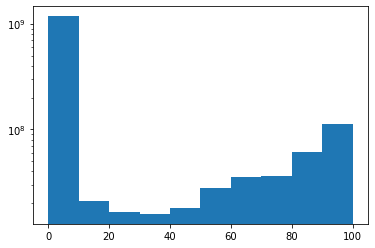

In [36]:
plt.hist(train_preds)
plt.yscale('log')

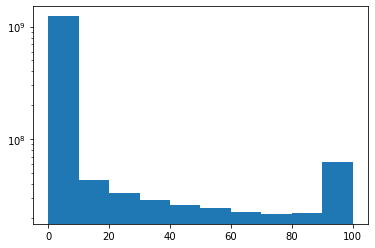

In [42]:
plt.hist(data_output)
plt.yscale('log')